In [1]:
# import useful libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl 
mpl.rcParams["figure.dpi"] = 150
mpl.rcParams["font.family"] = "serif"
import seaborn as sns
import os
import datetime as dt
# enable copy on write (default in pandas 3.0)
pd.options.mode.copy_on_write = True

In [2]:
import xgboost
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [3]:
def read_merged(weather, year):
    return pd.read_csv('../merged/merged_{}_{}.csv.gz'.format(weather, year))
lightning = [read_merged("lightning", year) for year in range(2015, 2024)]
light = pd.concat(lightning)
del lightning
del light['#ZDAY']
del light['Unnamed: 0']
light['LOG_TOTAL_COUNT'] = np.log10(light['TOTAL_COUNT'])
light['DATE'] = pd.to_datetime(light['DATE'])
light['MONTH'] = light['DATE'].dt.month

In [4]:
tor_train, tor_test = train_test_split(data.copy(), test_size=0.2, stratify=data.power_outage)
tor_tt, tor_val = train_test_split(tor_train.copy(), test_size=0.2, stratify=tor_train.power_outage)
outage = tor_tt[tor_tt['power_outage']==True]
no_outage = tor_tt[tor_tt['power_outage']==False]
no_outage= no_outage.sample(n=len(outage), random_state=101)
balanced_tt = pd.concat([outage,no_outage],axis=0)

In [5]:
features = ['LAT_mean', 'LON_mean', 'AVGDV_max', 'LLDV_max', 'MXDV_max', 'Month']

In [6]:
xbg_clf = xgboost.XGBClassifier(objective= 'binary:logistic', learning_rate=0.01, max_depth=12, n_estimators=440)
rf_clf =  RandomForestClassifier(n_estimators=300, max_depth=13)
logistic_clf = Pipeline([('scaler',StandardScaler()), ('logistic', LogisticRegression(C=0.1))])
knn = Pipeline([('scale', StandardScaler()),('knn_cls', KNeighborsClassifier(13))])

In [7]:
models = {'xgboost': xbg_clf,'Random Forest': rf_clf, 'Logistic Regression': logistic_clf, 'knn':knn}

In [8]:
for model in models.values():
    model.fit(balanced_tt[features], balanced_tt['power_outage'])

In [9]:
precisions, recalls, predictions ={}, {}, {}

In [10]:
for name, model in models.items():
    preds = model.predict(tor_val[features])
    predictions[name] = preds
    precisions[name] = precision_score(tor_val['power_outage'], preds)
    recalls[name] = recall_score(tor_val['power_outage'], preds)

In [11]:
for name in models:
    print(f"Precision for {name} is {precisions[name]}")
    print(f"Recall for {name} is {recalls[name]}")

Precision for xgboost is 0.14781922241957765
Recall for xgboost is 0.84251968503937
Precision for Random Forest is 0.14219698970161077
Recall for Random Forest is 0.8076490438695163
Precision for Logistic Regression is 0.06730319563522993
Recall for Logistic Regression is 0.6475440569928759
Precision for knn is 0.10116693991706047
Recall for knn is 0.7866516685414323


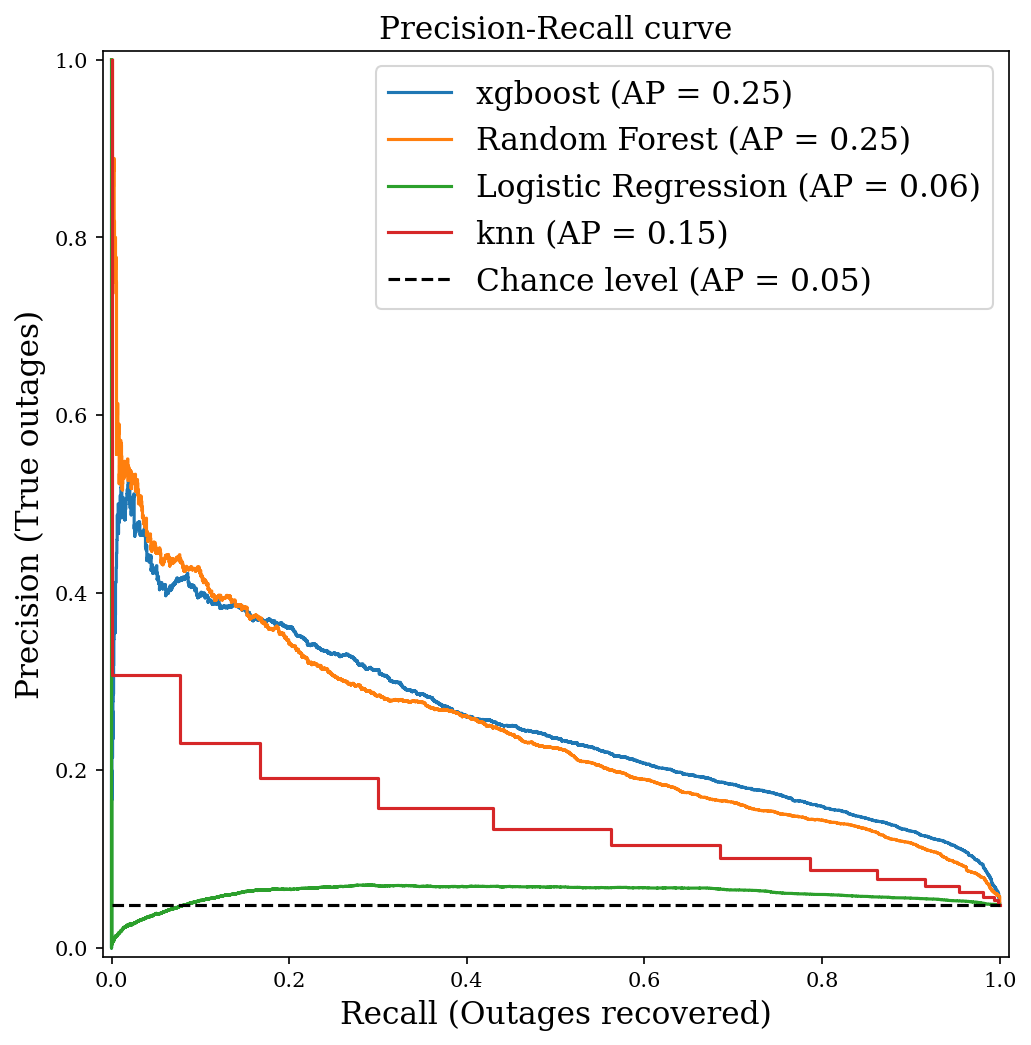

In [27]:
from sklearn.metrics import PrecisionRecallDisplay
fig, ax = plt.subplots(figsize=(12, 8))
for name, model in models.items():
    display = PrecisionRecallDisplay.from_estimator(
    model, tor_val[features], tor_val['power_outage'], plot_chance_level=name=='knn', 
        ax=ax, name=name)
    #display.plot(ax=ax, name=name)
_ = display.ax_.set_title("Precision-Recall curve", size=15)      
_ = display.ax_.legend(loc='upper right', fontsize=15)      
_ = display.ax_.set_xlabel('Recall (Outages recovered)', size=15)      
_ = display.ax_.set_ylabel('Precision (True outages)', size=15)      

plt.savefig("Tornados_results.png", dpi=500, bbox_inches='tight',
            facecolor='white', transparent=False)


# Feature importance

In [28]:
best_model = models['xgboost']

In [29]:
best_model.get_booster().get_score(importance_type='gain')

{'LAT_mean': 5.138552665710449,
 'LON_mean': 6.114282131195068,
 'AVGDV_max': 1.6865333318710327,
 'LLDV_max': 1.633029818534851,
 'MXDV_max': 2.298125743865967,
 'Month': 9.305929183959961}

# Confusion Matrix

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

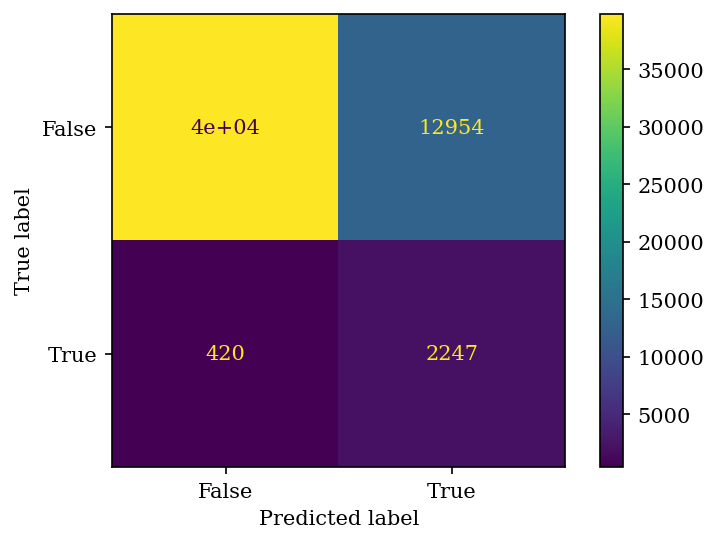

In [31]:
ConfusionMatrixDisplay.from_predictions(tor_val['power_outage'], predictions['xgboost'])

# Confusion matrix with a different threshold

In [32]:
probas = best_model.predict_proba(tor_val[features])

In [51]:
thr = 0.6

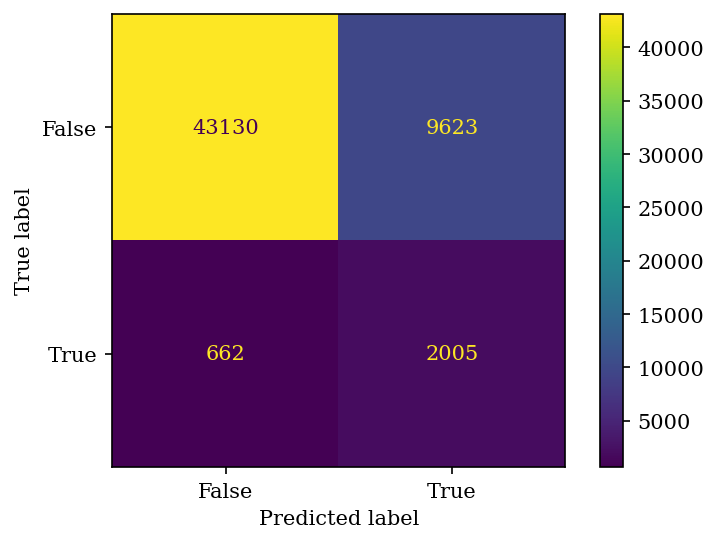

In [53]:
ConfusionMatrixDisplay.from_predictions(tor_val['power_outage'], probas[:,1]>thr)